# UK/Great Britain

Data extracted from PDF files.

In [61]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

## Fetch results

In [62]:
with open('../../data/raw/gbr.csv') as f:
    lines = f.readlines()

In [63]:
header = ['region', 'district'] + lines[0].strip().split(' ')

In [64]:
def is_region(x):
    return (len(x) < 75 and
            len(x) > 4 and
            not x.startswith('Con ') and
            not x.startswith('%'))

In [65]:
def is_junk(x):
    return x.startswith('%') or x.startswith('Con ') or ' total ' in x or (len(x) <= 4)

In [66]:
data = []
region = None

for line in lines:
    if is_junk(line):
        continue
    if is_region(line):
        region = line.strip()
        continue
    district = re.split('\s\d', line)[0]
    numbers = line.replace(district, '').strip().split(' ')
    data.append([region] + [district] + numbers)

In [67]:
df = pd.DataFrame(data, columns=header)

In [68]:
df = df[['region', 'district', 'Total', 'Electorate', 'Turnout']]

In [69]:
df['Total'] = df['Total'].str.replace(',', '').astype(int)
df['Electorate'] = df['Electorate'].str.replace(',', '').astype(int)
df['Turnout'] = df['Turnout'].str.replace('%', '').astype(float)

In [70]:
df.Total.sum() / df.Electorate.sum()

0.34977146382454655

## Merge

In [71]:
geo = gpd.read_file('../../data/shapefiles/gbr/Local_Authority_Districts'
                    '_December_2015_Full_Clipped_Boundaries_in_Great_Britain.shp')

In [72]:
df.district = df.district.str.replace('&', 'and')
df.district = df.district.str.replace(' City', '')

In [73]:
for k, v in {
    'Durham': 'County Durham',
    'Stockton': 'Stockton-on-Tees',
    'Barrow in Furness': 'Barrow-in-Furness',
    'Cheshire West': 'Cheshire West and Chester',
    'East Riding': 'East Riding of Yorkshire',
    'Kingston Upon Hull': 'Kingston upon Hull, City of',
    'Herefordshire': 'Herefordshire, County of',
    'Stratford on Avon': 'Stratford-on-Avon',
    'Vale White Horse': 'Vale of White Horse',
    'Woking Borough': 'Woking',
    'Bristol': 'Bristol, City of',
    #'Gibraltar': None,
    'Neath and Port Talbot': 'Neath Port Talbot',
    'Rhondda/Cynon/Taff': 'Rhondda Cynon Taf',
    'Ynys Mon': 'Isle of Anglesey',
    'Aberdeen': 'Aberdeen City',
    'Comhairle Nan Eilean Siar': 'Na h-Eileanan Siar',
    'Dundee': 'Dundee City',
    'City Of Edinburgh': 'City of Edinburgh',
    'City Of Glasgow': 'Glasgow City'}.items():
        df.district = df.district.replace(k, v)

In [74]:
geo = geo.merge(df[['district', 'Turnout']], left_on='lad15nm', right_on='district', how='left')

In [75]:
geo = geo[['district', 'Turnout', 'geometry']]
geo.columns = ['name', 'turnout', 'geometry']
geo['country'] = 'gbr'

In [76]:
geo = geo.to_crs(epsg=4326)

## Add Northern Ireland

In [77]:
ni = pd.read_csv('../../data/raw/gbr-ni.csv', header=None, skiprows=3, thousands=',',
                 names=['Council Area', 'District Electoral Area', 'Eligible Electorate',
                          'Total Votes Polled', 'Turnout'])

In [78]:
geo_ni = gpd.read_file('../../data/shapefiles/gbr_ni/OSNI_Open_Data_'
                       'Largescale_Boundaries__District_Electoral_Areas_2012.shp')

In [79]:
geo_ni = geo_ni.merge(ni,
                      left_on='FinalR_DEA',
                      right_on='District Electoral Area',
                      how='left')

In [80]:
geo_ni = geo_ni[['FinalR_DEA', 'Turnout', 'geometry']]
geo_ni.columns = ['name', 'turnout', 'geometry']
geo_ni['country'] = 'gbr'

In [81]:
geo = pd.concat([geo, geo_ni])

## Export

In [84]:
geo.to_file('../../data/processed/gbr')

## Visualize

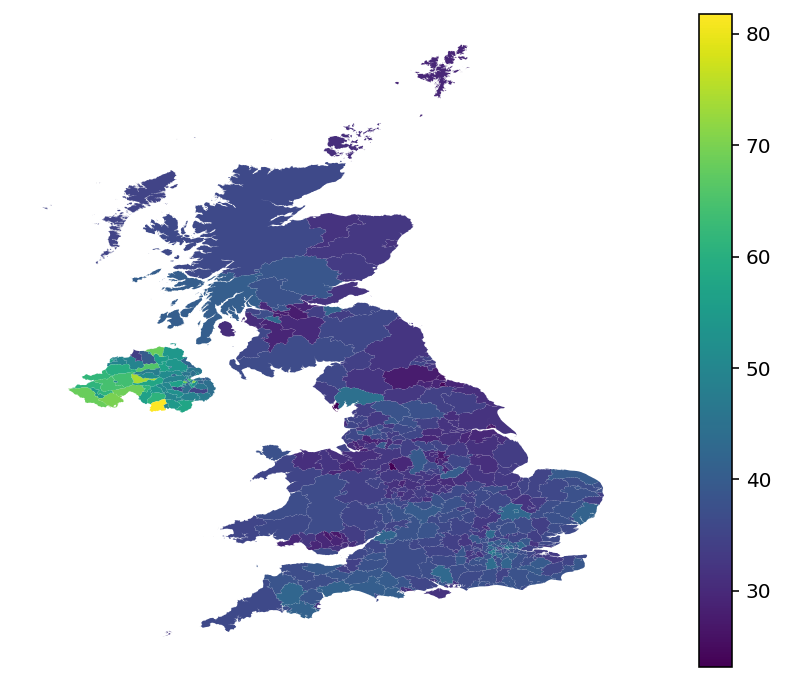

In [83]:
ax = geo.plot(figsize=(12, 6), column='turnout', legend=True);
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/gbr_choropleth.png')